## Introduction

The data for this project comes from the Lahman baseball database.  The data is a joined hitting and salary dataset that has basic statitistics (hits, walks, homeruns etc.) and the player's salary in dollars.

The goal of this project is to determine what metrics Major League Baseball teams value the most.  Major league players want to know what metrics they can improve in order to get a more valuable contract.  By the conclusion of the analysis, a model will be chosen and analyzed for feature importance using shap values.  The shap values will then be used to make recommendations for players.

In [63]:
import pandas as pd
import numpy as np
from plotnine import *

In [64]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from copy import deepcopy
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import randint
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.preprocessing import OneHotEncoder

In [65]:
df = pd.read_csv("posSalaries.csv")


In [66]:
df = df.dropna(subset=["salary"]) # remove na's in the salary data

In [67]:

df = df.drop_duplicates(subset=["playerID"]) # players that played for multiple teams in the same year had multiple rows in the dataset

In [68]:
df = df[df['AB'] != 0] # drop hitters that have 0 at-bats (they never got a single chance to hit)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## EDA

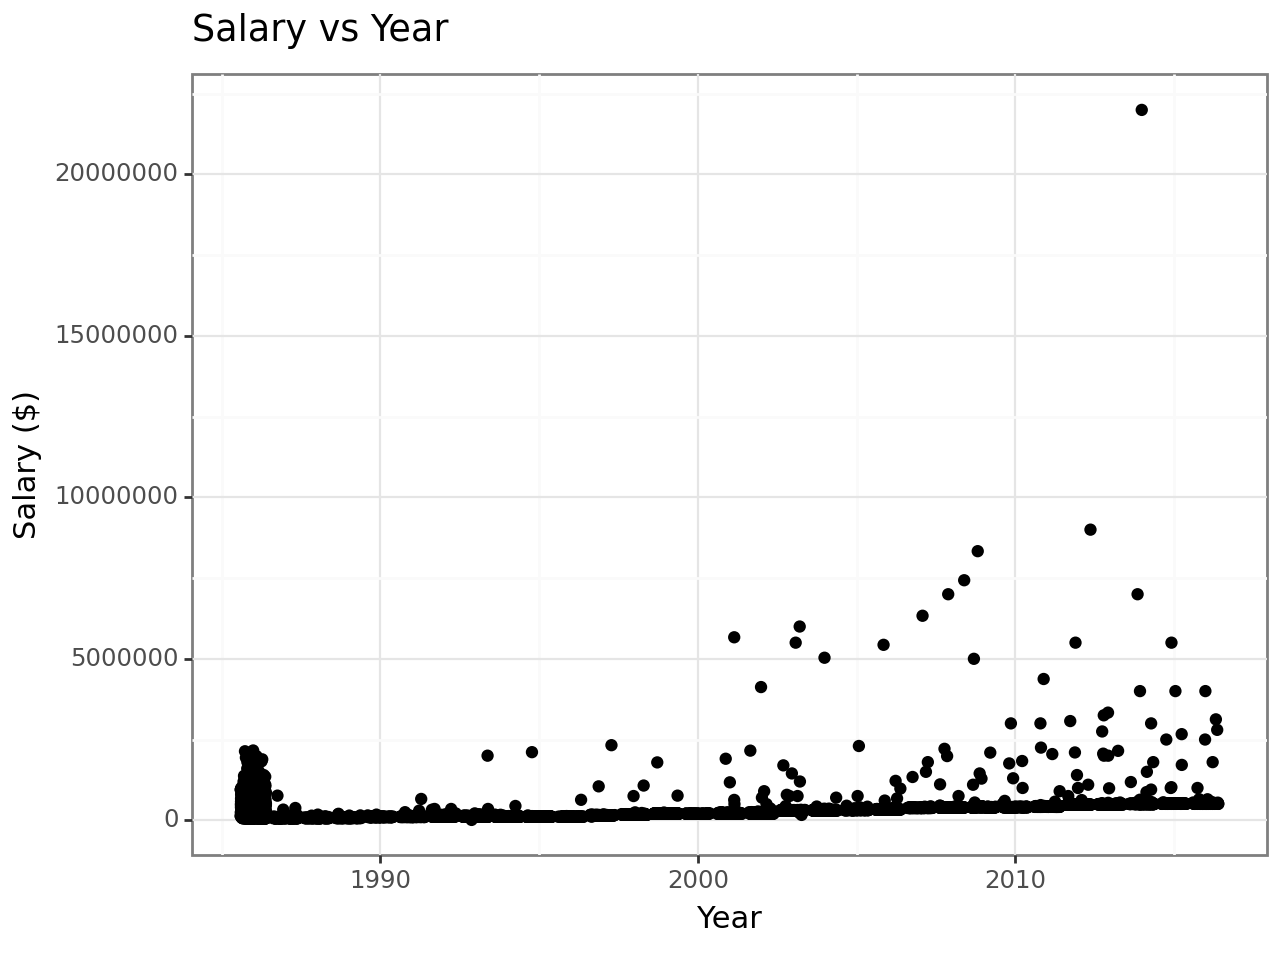

<Figure Size: (640 x 480)>

In [115]:
linePlot = (ggplot(df, mapping=aes(x="yearID", y="salary"))+
            geom_point(position = "jitter")+
            labs(
                x = "Year",
                y="Salary ($)",
                title = "Salary vs Year"
            ) + theme_bw()          
            )
linePlot

The above scatterplot shows that salaries have in general gone up by year.  It also has a major outlier that is over 20 million dollars and a exponential relationship between year and time.  Thus for the rest of this analysis the response variable will be the log of the player's salary 

In [70]:
df["logSalary"] = np.log(df["salary"])

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

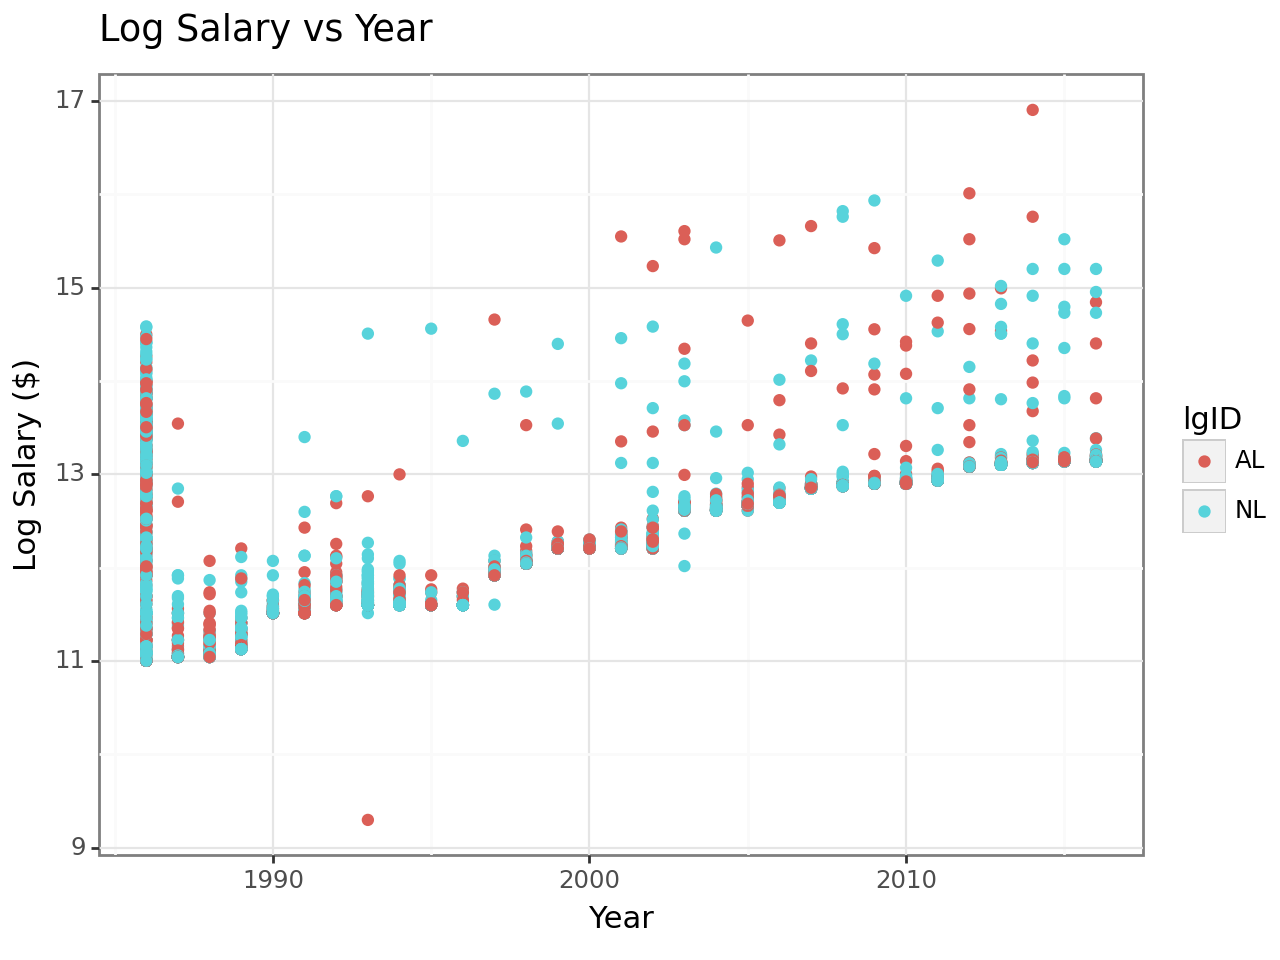

<Figure Size: (640 x 480)>

In [116]:
log_linePlot = (ggplot(df, mapping=aes(x="yearID", y="logSalary", color = "lgID"))+
            geom_point() +
            labs(

                x = "Year",
                y="Log Salary ($)",
                title = "Log Salary vs Year"
            ) + theme_bw())
log_linePlot

The above scatterplot shows the log of the player's salary by year and divided by the league that the player played in.  This shows that there is a mix of both AL (American League) an NL (National League) teams all throughout, but the highest paid player played for the AL (the Yankees).

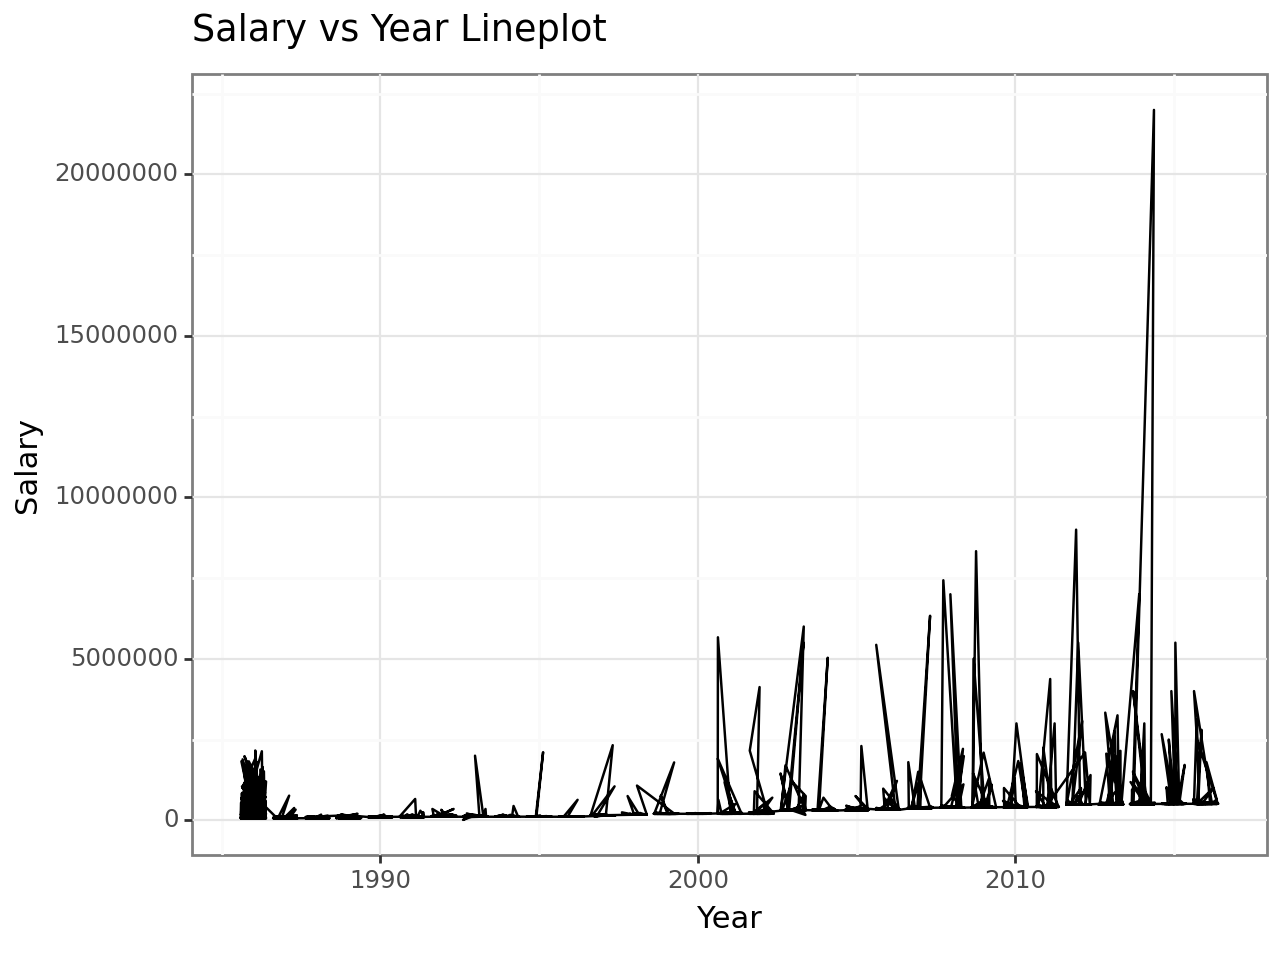

<Figure Size: (640 x 480)>

In [121]:

log_linePlot = (ggplot(df, mapping=aes(x="yearID", y="salary"))+
            geom_line(position="jitter") + labs(
                x = "Year",
                y = "Salary",
                title = "Salary vs Year Lineplot") + theme_bw())


In [ ]:
log_linePlot

One possible model that I could have used was a time-series model.  This line plot of year and salary shows the same trends as the scatterplot.  There is no obvious seasonality so I decided that it was not a necessary model.

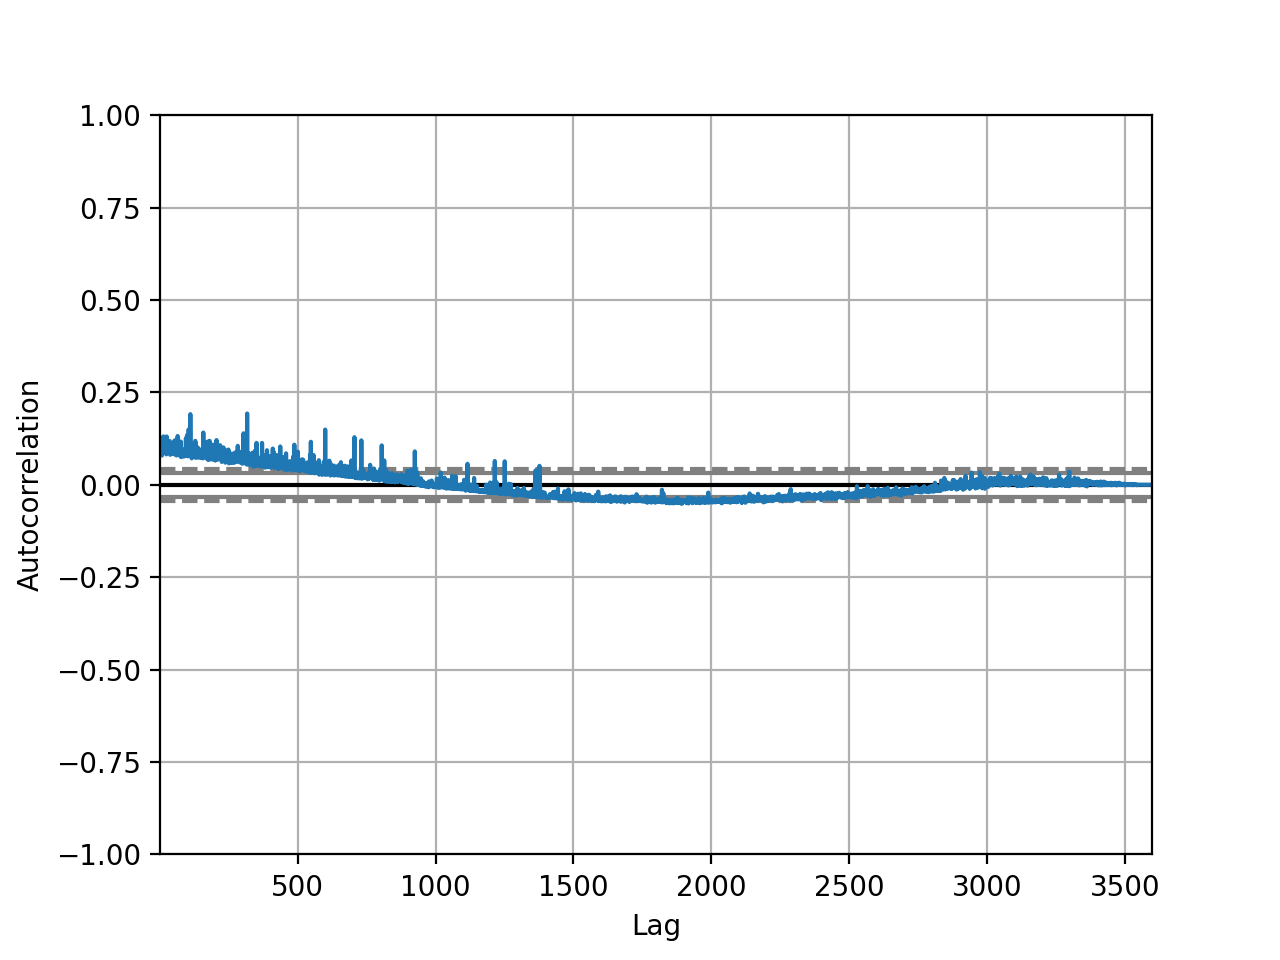

In [73]:
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import matplotlib.pyplot as plt
autocorrelation_plot(df["salary"])
plt.show()

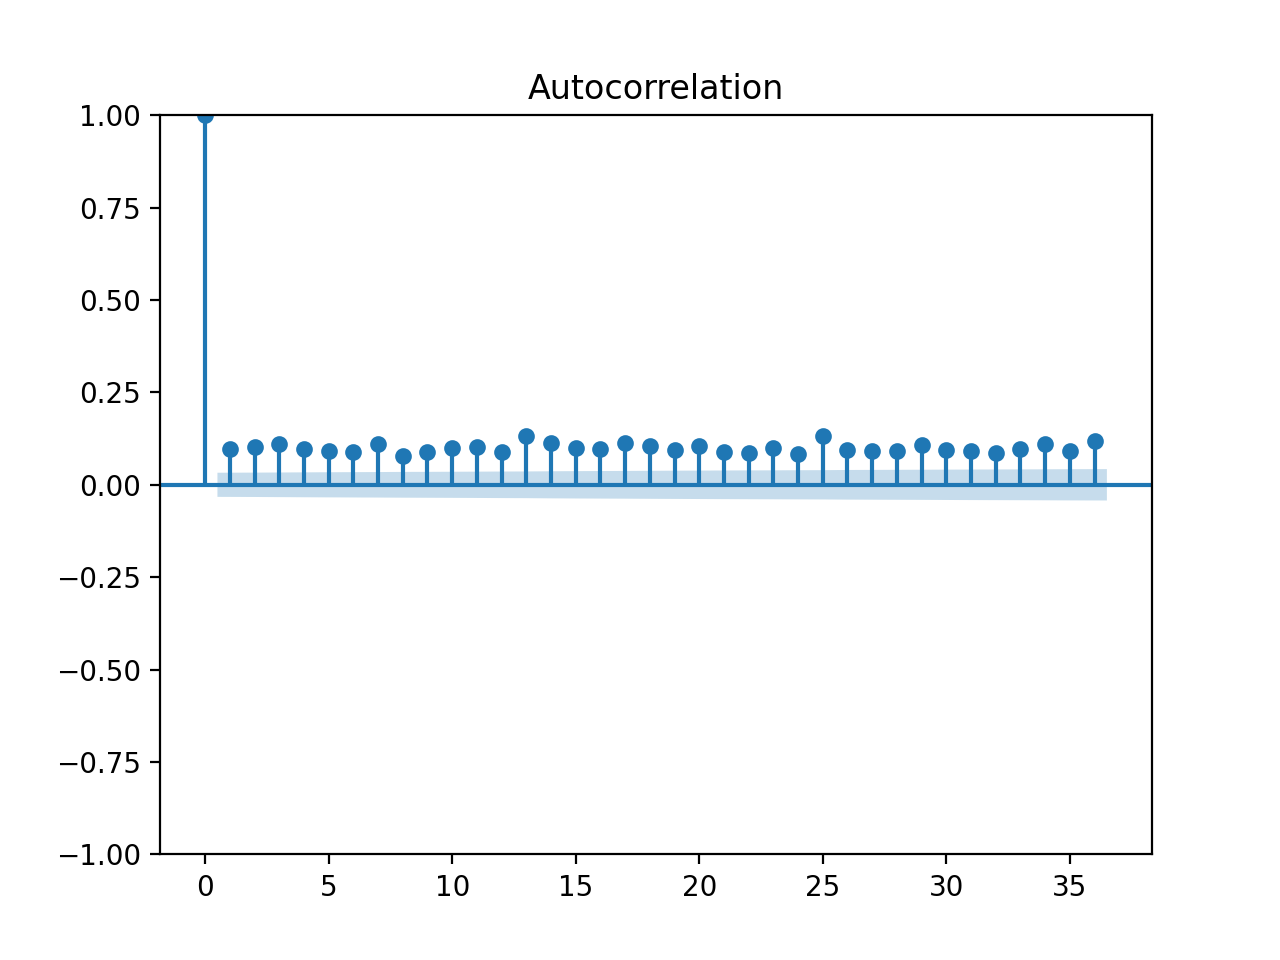

In [74]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df["salary"])
plt.show()

The two above plots show that there isn't autocorrelation between the salaries of the players.  This is important because it means that the salaries can be considered to be independent.

## Methods & Feature Engineering

In order to improve the predictions of the models, I added generated the columns OBP, SLG, OPS and BABIP (on base percentage, slugging percentage, on base + slugging, batting average on balls in play).  These features not only helped to lower the mean square error of the predictions, but also proved to have high shap values.  I also one-hot encoded the award names, team, notes (is just the position the award was for) and the league (AL or NL).

| Model | MSE |
|----------|----------|
| Linear Regression | .362 |
| K-Nearest Neighbors| .383 |
| Random Forest Regressor | .251 |
| Gradient Boosting | .2570 |
| Feedforward Neural Network| .392 |

- The linear regression model was a standard model with no hyperparameter tuning.  It generates coefficients from the data to make predictions about new data.
<br>
<br>
<br>
<br>
<br>
<br>
- The K-nearest neighbors model was tuned based on the k hyper-parameter. It uses points that are close-by to determine the value of the test data points.  The k values of 1, 3, 5, 7, 9, and 11 were explored.   
- The random forest model was not tuned and used 100 n_estimators.  Random forests create multiple decision trees and employ bagging to generate predictions.
- The gradient boosting model was tuned for learning rates of 0.001, 0.01, 0.1, 0.2, 0.3.  Boosted models fit the mistakes of the previous model and tries to correct them.

## Discussion on Model Selection

Overall the better models were the random forest regressor and the gradient boosted regressor.  The next level up was vanilla linear regression and k-nearest neighbors, and in last was the neural network.  The neural network had trouble with consitency as it would vary from a lower MSE of around .30 to a higher MSE of around .60.  It would run fast, but with too many nodes it also would over fit.  Once it was tuned it had more consistent performance, but it still could not beat any of the the other models.  The other model that potentially had some overfitting issues was the graident boosted regressor.  However, once the learning rate was tuned it was around where the random forest model was.  Overall the speed and and the performance of the random forest model was better than all of the other models.  K-nearest neighbors and the linear regession underfit the data thus leading to worse performance compared to the random forest model.

## Best Model

The best model was a random forest regressor.  It has a MSE of 0.251 and an R-squared of 0.625.  I used an n_estimators of 100 and then performed a SHAP feature importance analysis.  The most important feature was year (which was apparent from the scatterplot) however, the top 3  outside of year were the number of at-bats, the number of walks and then the number of hits.  Of note, the most commonly held value marker of a hitter batting average was outside the top 10.  On base percentage was fifth and slugging percentage was 6th in terms of shap values excluding year.  The only award to make the shap-value plot was rookie of the year. Part of this may be because there was not a lot of salary data for MVP winners. 

## Conclusion

The best model for this problem was the random forest regressor.  It has the best mean-squared error the highest R-squared and was fast to run.  The most valuable statistic for determining the value of a hitter was At-bats (i.e. the amount of chances to hit), walks and hits. This indicates that players that play the most are going to be paid the most.  It also means that hitters that have lots of hits and walks are also paid more.  However a player cannot control how often he gets a chance to hit, thus the percentage metrics are a better indication of where a hitter can improve his value.  Based on the shap values, a hitter should look to improve his on base percentage and slugging percentage not only batting average.    

An improvement that could be made would be to fit a linear regression model first using the year, and then model the residuals using machine learning.  This would account for the effect of year and then the machine learning could be used to find out what is valuable outside of the year the player was playing. More data could also be added for more player and more up-to date data could be added more the current players.

## Appendix Code and Graphs

In [75]:
y = df["logSalary"]
X = df.drop(["logSalary", "salary", "yearSal", "tie","Unnamed: 0","playerID"],axis=1)


In [76]:
X["avg"] = X["H"]/X["AB"] # Add a batting average statistic

In [77]:
X["OBP"] = (X["BB"] + X["H"] + X["IBB"] + X["HBP"])/(X["AB"]+X["BB"]+X["IBB"])
X["SLG"] = (X["X2B"]*2 + X["X3B"]*3 + X["HR"] + (X["H"]- X["X2B"]*2 + X["X3B"]*3 + X["HR"]))/X["AB"]
X["OPS"] = X["OBP"] + X["SLG"]
X["BABIP"] = (X["H"]-X["HR"])/(X["AB"]-X["SO"]-X["HR"]+X["SF"])


In [78]:
X['BABIP'].fillna(0, inplace=True)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=307)

In [80]:
cats = ["teamID", "lgID", "awardID","notes"]
# Define numerical features dynamically
numerical_features = X.select_dtypes(include=['int', 'float']).columns.tolist()


In [ ]:
numerical_features

In [82]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown="ignore"), cats),
        ('num', 'passthrough', numerical_features)
    ])

In [83]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [84]:
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

In [85]:
test_mse = mean_squared_error(y_test, y_pred)

In [86]:
test_mse

0.3623293043289021

In [87]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

In [88]:
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred_reg = pipeline.predict(X_test)

In [89]:
mse = mean_squared_error(y_test, y_pred_reg)

In [90]:
from sklearn.metrics import mean_squared_error, r2_score
r2_reg = r2_score(y_test, y_pred_reg)

In [91]:
r2_reg

0.4166494718205416

In [92]:
mse

0.39018931281445157

In [93]:
param_grid = {'regressor__n_neighbors': [1, 3, 5, 7, 9, 11]}

In [94]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best k value
best_k = grid_search.best_params_['regressor__n_neighbors']
print("Best value of k:", best_k)

Best value of k: 11


In [95]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred)



In [96]:
from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(y_test, y_pred)
r2

0.42682506379359497

In [97]:
mse

0.3833831010298545

In [98]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Create a pipeline with preprocessing and the Random Forest Regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', rf_regressor)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = pipeline.predict(X_test)

In [99]:
print(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(r2_rf)

0.25106082478749453
0.6246528033057623


In [104]:
X_pro = preprocessor.fit_transform(X_train)
feature_names_out = preprocessor.get_feature_names_out()

In [ ]:
feature_names_out

In [40]:
import shap
shap.initjs()

In [100]:
explainer = shap.TreeExplainer(rf_regressor,X_pro)
feature_names = X_train.columns.tolist()


In [ ]:
feature_names

In [ ]:
explainer = shap.Explainer(rf_regressor, X_pro, feature_names=feature_names_out)
shap_values = explainer.shap_values(X_pro)
# exp = shap.Explanation(shap_values[:,:,1], explainer.expected_value[1], X_pro, 
#                        feature_names=feature_names) 

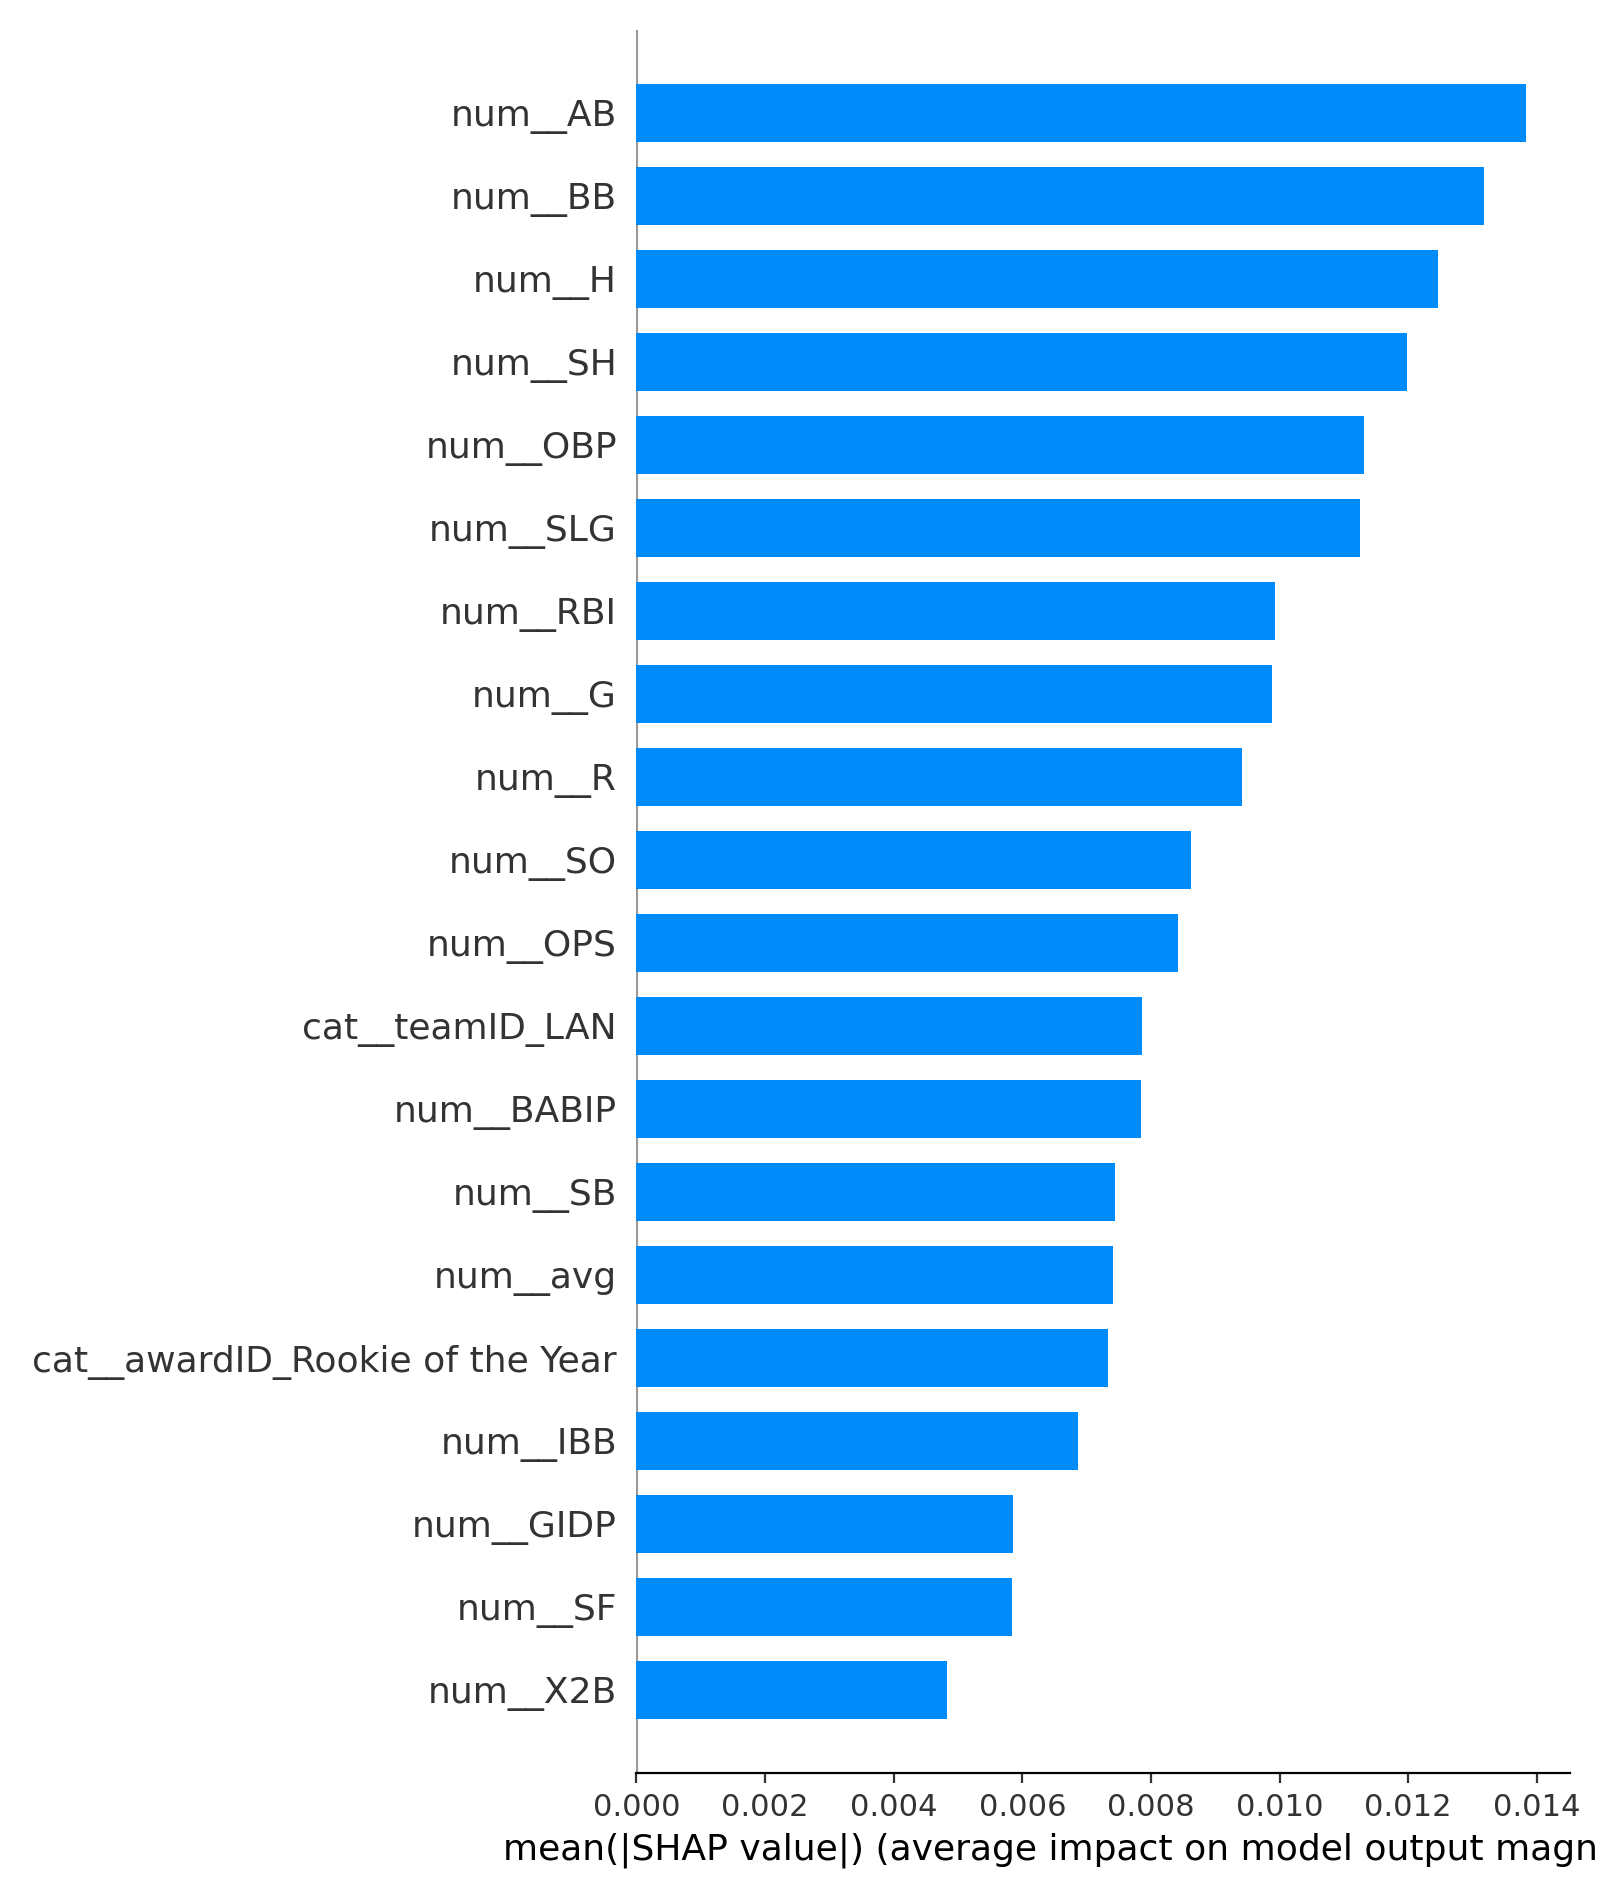

In [119]:
shap.summary_plot(shap_values, X_pro, feature_names = feature_names_out, plot_type="bar")

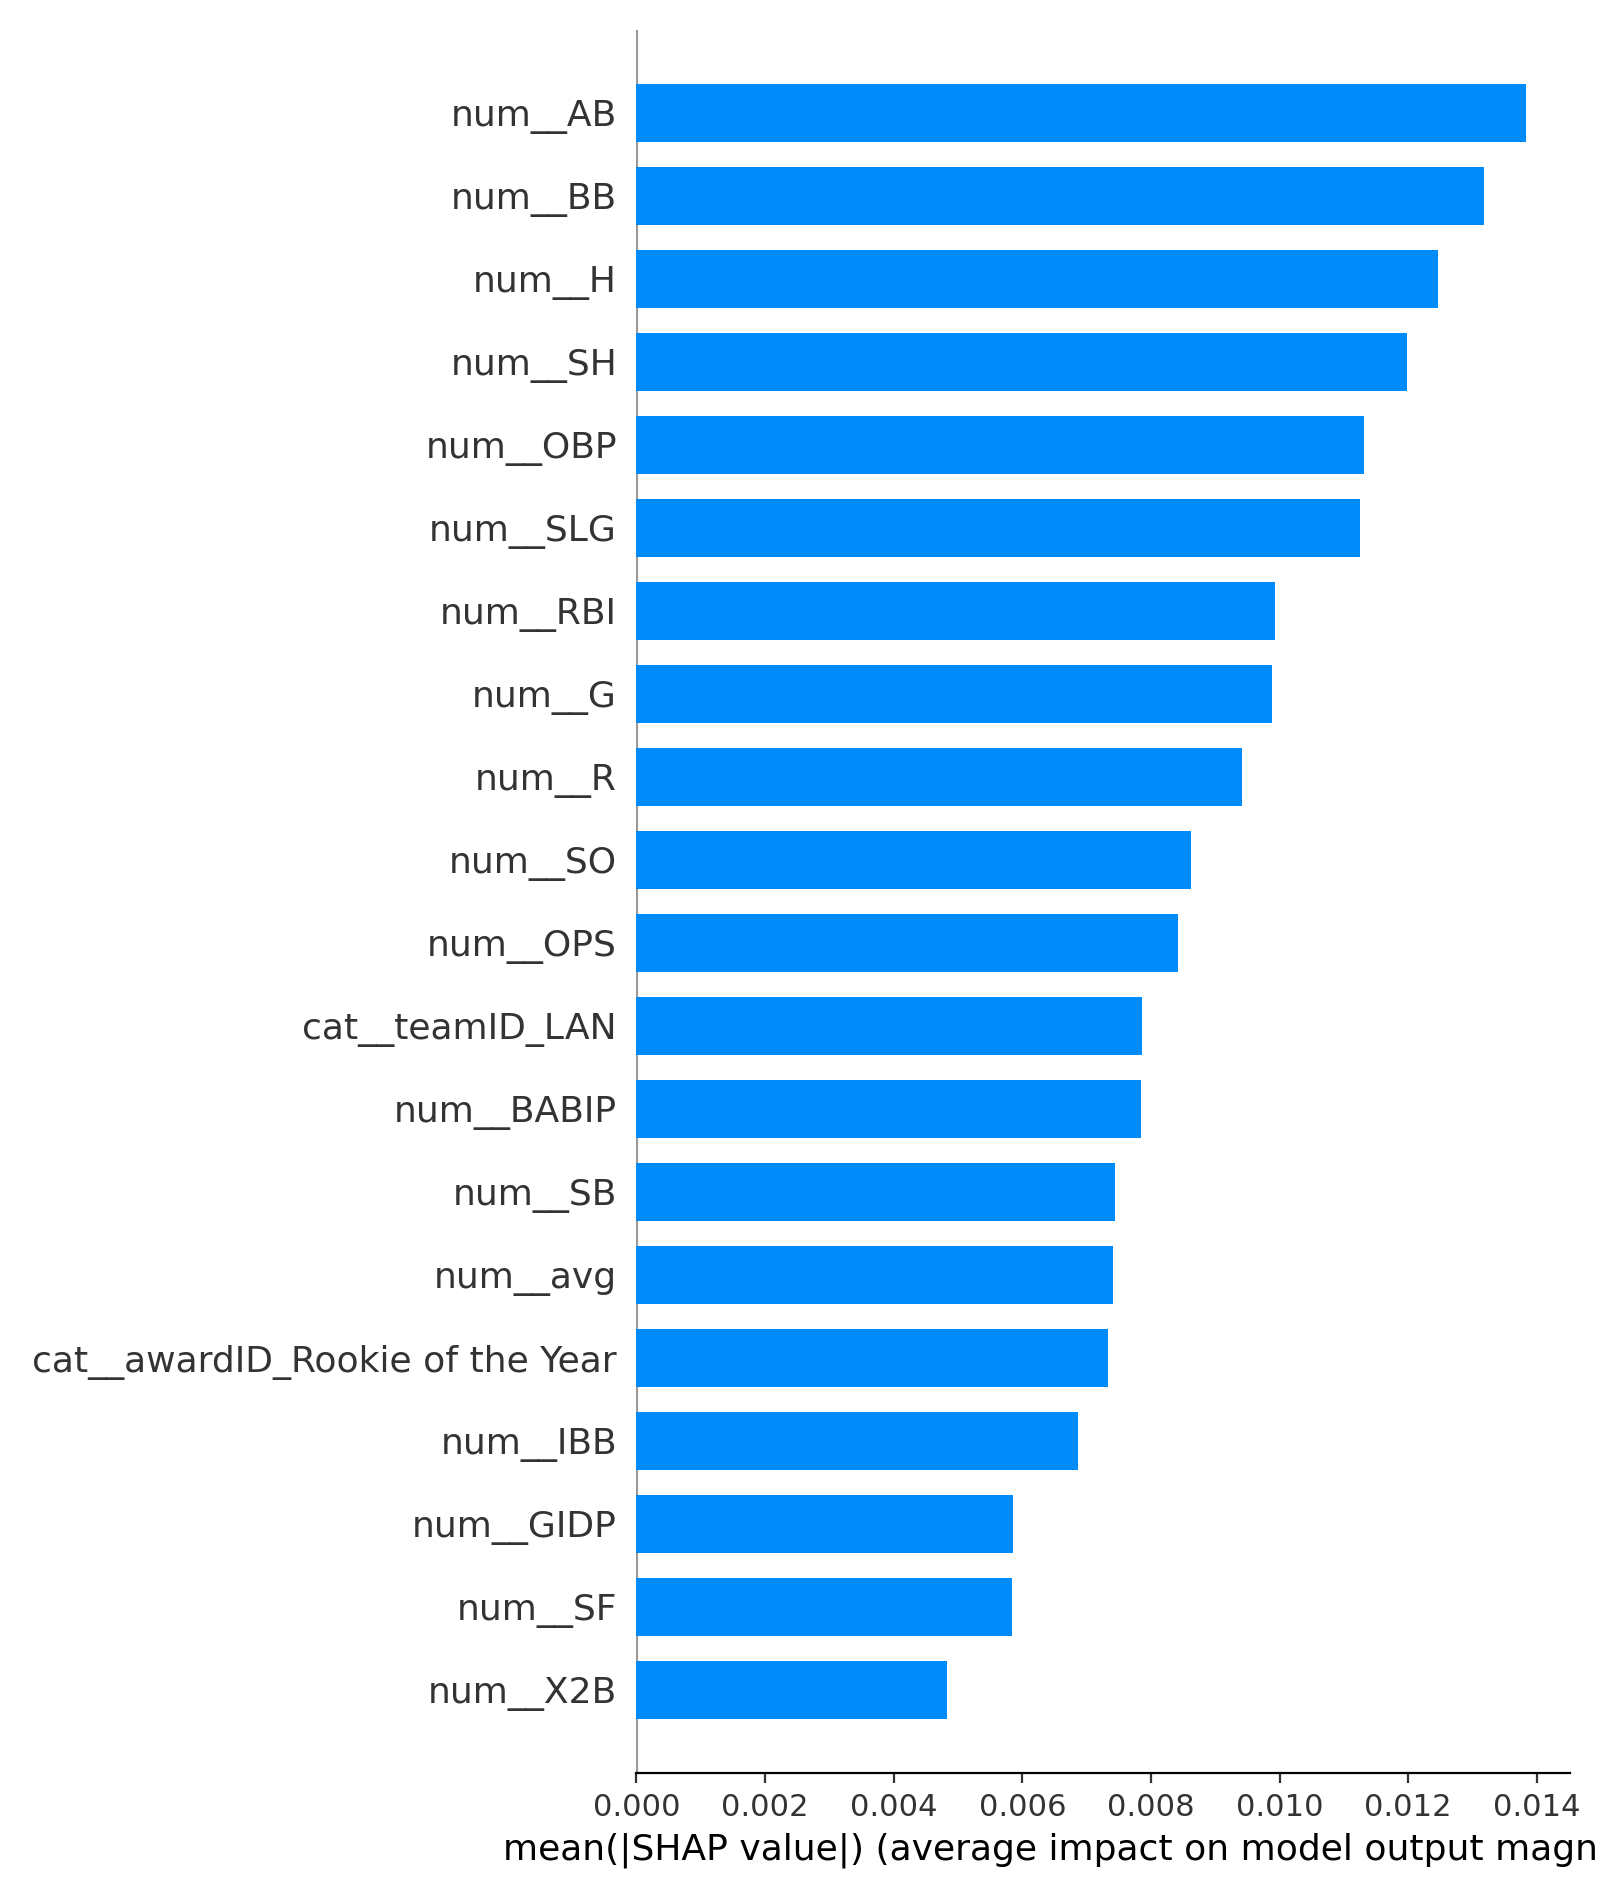

In [112]:
for i in range(len(shap_values)):
    max_abs_shap = np.max(np.abs(shap_values[i]))
    shap_values[i, np.argmax(np.abs(shap_values[i]))] = 0

# Plot SHAP summary plot with filtered SHAP values
shap.summary_plot(shap_values, X_pro, feature_names=feature_names_out,plot_type="bar")

In [60]:
param_grid = {
    'regressor__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
}


In [61]:
from sklearn.ensemble import GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Create a pipeline with preprocessing and the Gradient Boosting Regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', gb_regressor)
])

# Fit the pipeline on the training data
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best learning rate
best_learning_rate = grid_search.best_params_['regressor__learning_rate']
print("Best learning rate:", best_learning_rate)

# Use the best model for prediction
best_model = grid_search.best_estimator_
y_pred_gb = best_model.predict(X_test)

Best learning rate: 0.1


In [63]:
print(mean_squared_error(y_test, y_pred_gb))
print(r2_score(y_test, y_pred_gb))

0.25701050990714963
0.6203148154044605


In [121]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



In [144]:
preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown="ignore"), cats),
        ('num', 'passthrough', numerical_features),
        ('standard', StandardScaler(), numerical_features)
    ])

In [290]:
X_train_nn = preprocessor2.fit_transform(X_train)
X_test_nn = preprocessor2.transform(X_test)
X_train_nn = X_train_nn.astype("float")
X_test_nn = X_test_nn.astype("float")

In [292]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [309]:
import shutil

# Delete the tuner directory to start fresh
shutil.rmtree('my_dir/my_project', ignore_errors=True)

In [310]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split

# Define the function to create the model
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32), activation='linear', input_shape=(X_train_nn.shape[1],)))
    model.add(Dropout(rate=hp.Choice('dropout_input', values=[0.2, 0.3, 0.4])))
    model.add(BatchNormalization())
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), activation='linear'))
        model.add(Dropout(rate=hp.Choice(f'dropout_{i}', values=[0.2, 0.3, 0.4])))
        model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model





In [ ]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # You can increase this number for more exhaustive search
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project')

# Perform the search for the best hyperparameters
tuner.search(X_train_nn, y_train, epochs=80, validation_data=(X_test_nn, y_test))

# Print the summary of the search
tuner.results_summary()

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps)

# Build the model with the best hyperparameters



In [ ]:
model = tuner.hypermodel.build(best_hps)

In [308]:
tuner.results_summary()

Results summary
Results in my_dir\my_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
units_input: 256
dropout_input: 0.4
num_layers: 1
units_0: 224
dropout_0: 0.4
learning_rate: 0.01
Score: 0.5988154411315918

Trial 0 summary
Hyperparameters:
units_input: 224
dropout_input: 0.3
num_layers: 1
units_0: 256
dropout_0: 0.4
learning_rate: 0.001
Score: 0.6579942107200623

Trial 3 summary
Hyperparameters:
units_input: 128
dropout_input: 0.4
num_layers: 3
units_0: 192
dropout_0: 0.4
learning_rate: 0.001
units_1: 32
dropout_1: 0.2
units_2: 32
dropout_2: 0.2
Score: 0.6866323351860046

Trial 4 summary
Hyperparameters:
units_input: 160
dropout_input: 0.4
num_layers: 3
units_0: 224
dropout_0: 0.2
learning_rate: 0.0001
units_1: 192
dropout_1: 0.3
units_2: 64
dropout_2: 0.4
Score: 119.62092590332031

Trial 2 summary
Hyperparameters:
units_input: 224
dropout_input: 0.4
num_layers: 1
units_0: 32
dropout_0: 0.2
learning_rate: 0.0001
Score: 131

In [306]:
best_hps
print("Best hyperparameters:", best_hps)
model = tuner.hypermodel.build(best_hps)


Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001F83ECF5FD0>


In [302]:
tuner.results_summary()

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps)

Results summary
Results in my_dir\my_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
units_input: 256
dropout_input: 0.4
num_layers: 1
units_0: 224
dropout_0: 0.4
learning_rate: 0.01
Score: 0.5988154411315918

Trial 0 summary
Hyperparameters:
units_input: 224
dropout_input: 0.3
num_layers: 1
units_0: 256
dropout_0: 0.4
learning_rate: 0.001
Score: 0.6579942107200623

Trial 3 summary
Hyperparameters:
units_input: 128
dropout_input: 0.4
num_layers: 3
units_0: 192
dropout_0: 0.4
learning_rate: 0.001
units_1: 32
dropout_1: 0.2
units_2: 32
dropout_2: 0.2
Score: 0.6866323351860046

Trial 4 summary
Hyperparameters:
units_input: 160
dropout_input: 0.4
num_layers: 3
units_0: 224
dropout_0: 0.2
learning_rate: 0.0001
units_1: 192
dropout_1: 0.3
units_2: 64
dropout_2: 0.4
Score: 119.62092590332031

Trial 2 summary
Hyperparameters:
units_input: 224
dropout_input: 0.4
num_layers: 1
units_0: 32
dropout_0: 0.2
learning_rate: 0.0001
Score: 131

In [ ]:
mse = model.evaluate(X_test_nn, y_test)[1]  # 1 corresponds to the index of MSE in the metrics list

# Print the MSE
print("Mean Squared Error:", mse)

In [267]:

# def create_model(input_shape):
#     model = Sequential([
#         Dense(64, activation='relu', input_shape=input_shape),
#         Dropout(0.2),  # Adding dropout with a rate of 0.2 (20%)
#         BatchNormalization(),
#         Dense(32, activation='relu'),
#         Dropout(0.2),  # Adding dropout with a rate of 0.2 (20%)
#         Dense(16, activation='relu'),
#         Dropout(0.2),  # Adding dropout with a rate of 0.2 (20%)
#         Dense(16, activation='relu'),
#         Dropout(0.2),  # Adding dropout with a rate of 0.2 (20%)
        
#         Dense(1, activation='linear')
#     ])
    
#     model.compile(optimizer='adam',
#                   loss='mean_squared_error',
#                   metrics=['mse'])
    
#     return model

#Assuming X_train and y_train are your training features and labels respectively,
#and X_test and y_test are your test features and labels respectively.
#You should replace these placeholders with your actual data.



In [ ]:
# keras_regressor = KerasRegressor(build_fn=create_model, verbose=0,input_shape=(110,))

# # Define the grid of hyperparameters
# param_grid = {
#     'batch_size': [32, 64],
#     'epochs': [50, 100],
#     'optimizer': ['adam', 'rmsprop']
# }

# # Perform grid search
# grid_search = GridSearchCV(estimator=keras_regressor, param_grid=param_grid, cv=3)
# grid_result = grid_search.fit(X_train_nn, y_train)

# # Print the best hyperparameters
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
# input_shape = (110,)

# # Create the model
# model2 = create_model(input_shape)

# # Train the model
# model2.fit(X_train_nn, y_train, epochs=200, batch_size=32, validation_data=(X_test_nn, y_test))

# # Evaluate the model
# loss, mse = model2.evaluate(X_test_nn, y_test)

In [269]:
# y_pred = model2.predict(X_test_nn)

# # Calculate MSE manually
# mse_manual = mean_squared_error(y_test, y_pred)
# print(f'Manually Calculated Test MSE: {mse_manual}')

29/29 [==============================] - 0s 1ms/step
Manually Calculated Test MSE: 0.6747493510820899
